In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import japanize_matplotlib

In [5]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate', 'LowActivityHourws']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

def create_user_feature(user_id):
    output_df = use_feature_df[use_feature_df['UserID'] == user_id].reset_index(drop=True)
    output_df['TargetDate'] = output_df['TargetDate'].dt.date
    return output_df

def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    _piv_df['mean'] = _piv_df.mean(axis=1)
    _piv_df['y'] = _piv_df['mean'].apply(lambda x: 1 if x >= _piv_df['mean'].mean()+_piv_df['mean'].std() else 0)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 3))
    return _piv_df


## マハラノビス距離のユーザIDごとの相関を計算する

In [6]:
# 共分散行列の逆行列
def inv_cov(Z):
    #標準化後のベクトルを入力する
    #標準化した後なので相関行列と分散共分散行列は一致する
    c = np.cov(Z.T)
    return np.linalg.pinv(c)

In [7]:
# users = keio_df['UserID'].unique()
users = [
    # 1504, 
    1505, 
1755, 
1781, 
1774, 
1773
]
user_id = users[0]

1505


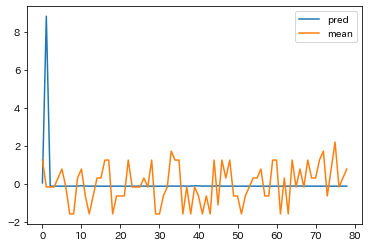

1755


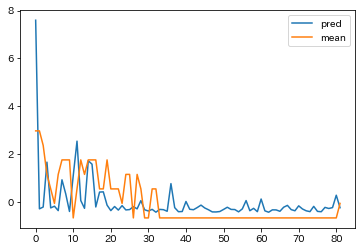

1781


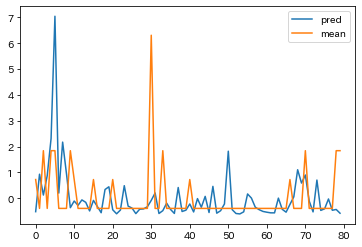

1774


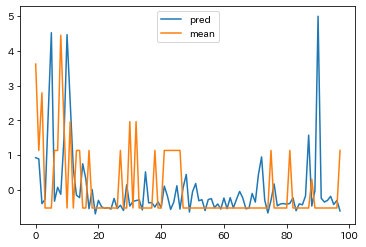

1773


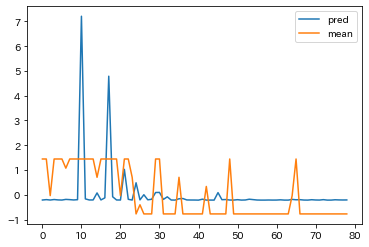

,mean
1505,-0.01593
1755,0.452861
1781,0.209044
1774,0.028403
1773,0.255554


In [8]:
score_df = pd.DataFrame(index=users, columns=['mean'])
for user_id in users:
    print(user_id)
    X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    y = create_y(user_id)
    df = pd.merge(X, y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
            'DeepSleepRate', 'LowActivityHourws']]
    _X = _X.fillna(_X.mean())
    for i in range(7, len(df)):
        scaler = StandardScaler()
        if (df['y'].iloc[:i] == 0).sum() > 3:
            use_X = _X.iloc[:i][df['y'].iloc[:i] == 0]
        else:
            use_X = _X.iloc[:i]
        scaler.fit(use_X)
        Z = scaler.transform(use_X)
        inv_C = inv_cov(Z)
        _Z = scaler.transform(_X.iloc[[i]])
        md = np.dot(_Z, inv_C)
        MD = np.dot(md, _Z.T) / _Z.shape[1]
        df.loc[i, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
score_df


In [9]:
score_df.mean()

mean    0.185986
dtype: float64